In [2]:
from HurdatReader import *
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import cartopy.crs as ccrs
from geopy import distance
import scipy.stats as st
hurdat = readHurdat('Data/Hurdat.txt')
BOXhurdat = trimHurdat(hurdat, latMin = 40, lonMax = -70, timeMin = dt.datetime(1700, 1, 1, tzinfo = dt.timezone.utc))

In [3]:
def plotStorm(lonlist, latlist, ax):
    ax.plot(lonlist, latlist, transform=ccrs.Geodetic(), alpha = 0.3)

In [4]:
def positionBeforeArrival(storm, tMinusTime, lon_min, lon_max, lat_min, lat_max):
    if type(tMinusTime) == int or type(tMinusTime) == float:
        tMinusTime = dt.timedelta(hours=-tMinusTime)
    
    keyTime = None
    for i, (lon, lat) in enumerate(zip(storm['data']['lon'], storm['data']['lat'])):
        if lon >= lon_min and lon <= lon_max and lat >= lat_min and lat <= lat_max:
            keyTime = storm['data']['datetime'][i] + tMinusTime
            break
    
    if keyTime is None: #this means it doesn't enter our bounding box and can't be plotted
        return
    
    bounds = getSynopticBounds(storm, keyTime)
    
    if bounds is None: #this means we are too early/late in data and it can't be plotted
        return
    
    if type(bounds) == int:
        return ((storm['data']['lon'][bounds], storm['data']['lat'][bounds]), storm)
    else:
        #god i hate spherical coordinates
        velocity = (distance.distance((storm['data']['lat'][bounds[0]], storm['data']['lon'][bounds[0]]), 
                                (storm['data']['lat'][bounds[1]], storm['data']['lon'][bounds[1]])).km / 
                    (storm['data']['datetime'][bounds[1]] - storm['data']['datetime'][bounds[0]]).total_seconds())
        time = (keyTime - storm['data']['datetime'][bounds[0]]).total_seconds()
        stormDistance = velocity * time
        dest = distance.distance(kilometers=stormDistance).destination(
            (storm['data']['lat'][bounds[0]], storm['data']['lon'][bounds[0]]), 
            bearing = twoPointBearing(storm['data']['lon'][bounds[0]], storm['data']['lat'][bounds[0]],
                                     storm['data']['lon'][bounds[1]], storm['data']['lat'][bounds[1]]))
        return((dest.longitude, dest.latitude), storm)


In [5]:
#This gets the index or two indicies of the 2 hurricane observation steps bounding a given datetime
def getSynopticBounds(storm, datetime):
    for i in range(len(storm['data']['datetime']) -1):
        if datetime == storm['data']['datetime'][i]:
            return i
        if datetime == storm['data']['datetime'][i+1]:
            return i+1
        if datetime > storm['data']['datetime'][i] and datetime < storm['data']['datetime'][i + 1]:
            return i, i+1

In [6]:
#This looks at the status of the storm at the point nearest to the given lonlat
def statusNearLocation(storm, lon_site, lat_site):
    #the smallest great circle distance of 2 points on a globe is 20037.5 km, so setting it to start at 25000km is an easy way to prime it
    min_dist = 25000
    status_final = None
    for lon, lat, status in zip(storm['data']['lon'], storm['data']['lat'], storm['data']['system status']):
        if distance.distance((lat_site, lon_site), (lat, lon)) < min_dist:
            min_dist = distance.distance((lat_site, lon_site), (lat, lon))
            status_final = status
            
    return status_final

In [7]:
def lonLatToXYZ(lon, lat):
    return (np.cos(np.pi / 180 * lon) * np.cos(np.pi / 180 * lat), 
            np.sin(np.pi / 180 * lon) * np.cos(np.pi / 180 * lat),
            np.sin(np.pi / 180 * lat))

def XYZtoLonLat(x, y, z):
    return (180 / np.pi * np.arctan2(y,x), 
            90 - 180 / np.pi * np.arctan2(np.sqrt(x ** 2 + y ** 2), z))

def twoPointBearing(lon1, lat1, lon2, lat2):
    x_bearing = (np.cos(np.pi / 180 * lat2) * 
                 np.sin(np.pi / 180 * (lon2 - lon1)))
    y_bearing = (np.cos(np.pi / 180 * lat1) * np.sin(np.pi / 180 * lat2) -
                 (np.sin(np.pi / 180 * lat1) * np.cos(np.pi / 180 * lat2) *
                  np.cos(np.pi / 180 * (lon2 - lon1))))
    bearing = 180 / np.pi * np.arctan2(x_bearing, y_bearing)
    return bearing

163 storms plotted


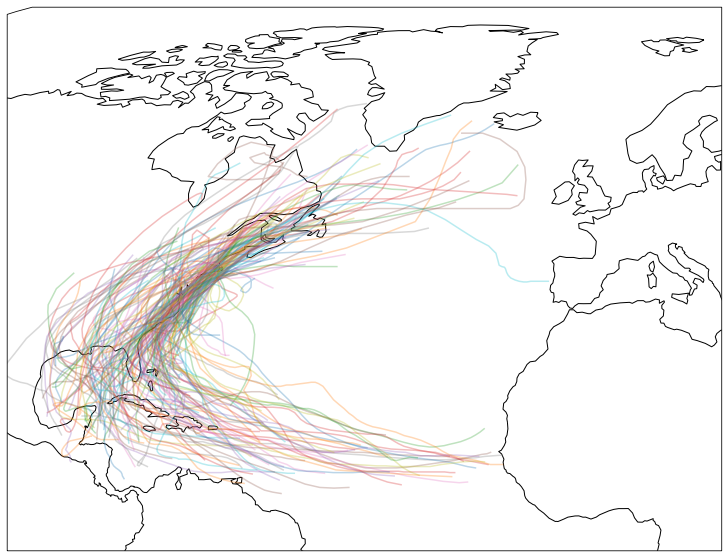

In [8]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.coastlines()

ax.set_extent([-100, 20, 0, 90], crs=ccrs.Geodetic())
#ax.set_global()

ax.plot(-71.186996, 41.966770, 'o', transform=ccrs.Geodetic())

sum = 0
for key in BOXhurdat:
    if statusNearLocation(BOXhurdat[key], -71.186996, 41.966770) in ['TD', 'HU', 'TS', 'SS', 'EX']:
        #if BOXhurdat[key]['idcode'] == 'AL051961':
        plotStorm(BOXhurdat[key]['data']['lon'], BOXhurdat[key]['data']['lat'], ax)
    sum +=1
    
print(f'{sum} storms plotted')
    
plt.show()

In [15]:
#from https://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix/ 
#and https://stackoverflow.com/questions/12301071/multidimensional-confidence-intervals

def cov_ellipse(cov, q=None, nsig=None, **kwargs):
    """
    Parameters
    ----------
    cov : (2, 2) array
        Covariance matrix.
    q : float, optional
        Confidence level, should be in (0, 1)
    nsig : int, optional
        Confidence level in unit of standard deviations. 
        E.g. 1 stands for 68.3% and 2 stands for 95.4%.

    Returns
    -------
    width, height, rotation :
         The lengths of two axises and the rotation angle in degree
    for the ellipse.
    """

    if q is not None:
        q = np.asarray(q)
    elif nsig is not None:
        q = 2 * st.norm.cdf(nsig) - 1
    else:
        raise ValueError('One of `q` and `nsig` should be specified.')
    r2 = st.chi2.ppf(q, 2)

    val, vec = np.linalg.eigh(cov)
    width, height = 2 * np.sqrt(val[:, None] * r2)
    rotation = np.degrees(np.arctan2(*vec[::-1, 0]))

    return width, height, rotation

In [16]:
#potential todo: use a kent distribution rather than what I'm doing now

def plotTMinusPosition(hurdat, tMinus, stormType, lon_min=-180, lon_max=180, lat_min=-90, lat_max=90, storm_alpha=0.5, bounds = None):
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    ax.coastlines()
    if bounds is None:
        bounds = [-100, -30, 10, 90]

    ax.set_extent(bounds, crs=ccrs.Geodetic())
    #ax.set_global()



    position_list = []
    lon_list = []
    lat_list = []
    storm_list = []
    
    for key in hurdat:
        position = positionBeforeArrival(hurdat[key], tMinus, lon_min, lon_max, lat_min, lat_max)

        if position is not None:
            position_list.append(position[0])
            lon_list.append(position[0][0])
            lat_list.append(position[0][1])
            storm_list.append(position[1])

    lon_plot = []
    lat_plot = []
    
    for i, (sLon, sLat, storm) in enumerate(zip(lon_list, lat_list, storm_list)):
        if statusNearLocation(storm, lon_min, lat_min) in stormType:
            ax.plot(sLon, sLat, 'o', transform=ccrs.Geodetic(), alpha = storm_alpha)
            lon_plot.append(sLon)
            lat_plot.append(sLat)
            
            
    lonLatList = np.stack([lon_plot, lat_plot], axis = 1)
    
    mean = np.mean(lonLatList, axis=0)
    cov = np.cov(lonLatList, rowvar=0)
    mvNorm = st.multivariate_normal(mean, cov=cov)

    STEP = 0.1
    gridX = np.arange(bounds[0], bounds[1], STEP)
    gridY = np.arange(bounds[2], bounds[3], STEP)
    meshX, meshY = np.meshgrid(gridX, gridY)
    pos = np.dstack([meshX, meshY])
    
    #ax.contourf(meshX, meshY, mvNorm.pdf(pos), transform=ccrs.PlateCarree(), levels = 10)
    
    S3width, S3height, S3rotation = cov_ellipse(cov, nsig=3)
    ax.add_patch(Ellipse(mean, S3width, S3height, transform=ccrs.Geodetic(), 
                         angle=S3rotation, facecolor='White', edgecolor='red', label = '3 sigma interval'))
    
    S2width, S2height, S2rotation = cov_ellipse(cov, nsig=2)
    ax.add_patch(Ellipse(mean, S2width, S2height, transform=ccrs.Geodetic(), 
                         angle=S2rotation, facecolor='White', edgecolor='blue', label = '2 sigma interval'))
    
    S1width, S1height, S1rotation = cov_ellipse(cov, nsig=1)
    ax.add_patch(Ellipse(mean, S1width, S1height, transform=ccrs.Geodetic(), 
                         angle=S1rotation, facecolor='White', edgecolor='green', label = '1 sigma interval'))
    
    
    ax.legend()
    
    ax.plot([lon_min, lon_max], [lat_min, lat_min], transform=ccrs.PlateCarree(), color = 'pink')
    ax.plot([lon_min, lon_max], [lat_max, lat_max], transform=ccrs.PlateCarree(), color = 'pink')
    ax.plot([lon_max, lon_max], [lat_min, lat_max], transform=ccrs.PlateCarree(), color = 'pink')
    ax.plot([lon_min, lon_min], [lat_min, lat_max], transform=ccrs.PlateCarree(), color = 'pink')
              
    ax.plot(*mean, '+', transform=ccrs.PlateCarree(), color = 'black')

    print(f'{len(lonLatList)} storms plotted')
    
    plt.show()

43 storms plotted


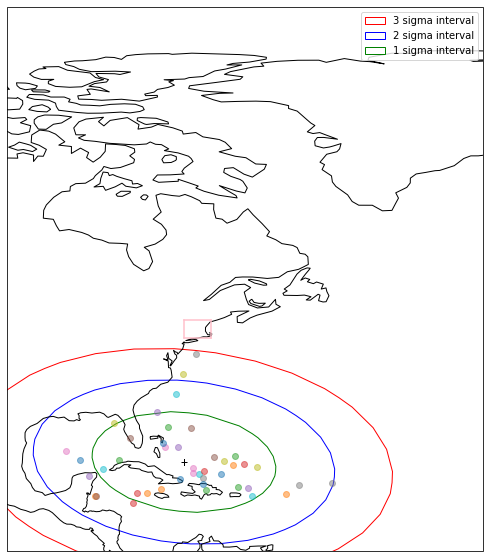

In [17]:
plotTMinusPosition(hurdat, 120, ['TD', 'HU', 'TS', 'SS', 'EX'], lon_min=-74, lon_max=-70, lat_min=41.25, lat_max=44)

64 storms plotted


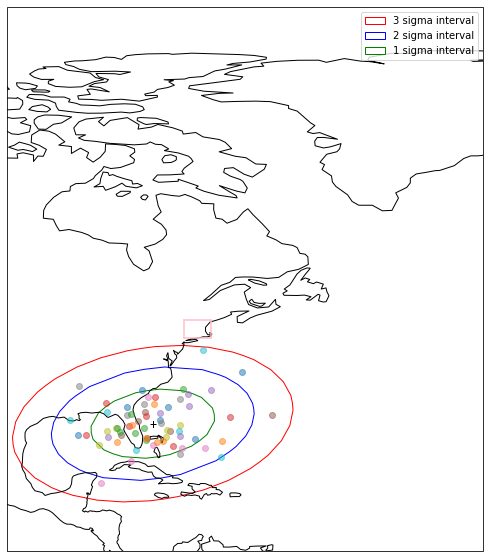

In [18]:
plotTMinusPosition(hurdat, 60, ['TD', 'HU', 'TS', 'SS', 'EX'], lon_min=-74, lon_max=-70, lat_min=41.25, lat_max=44)

68 storms plotted


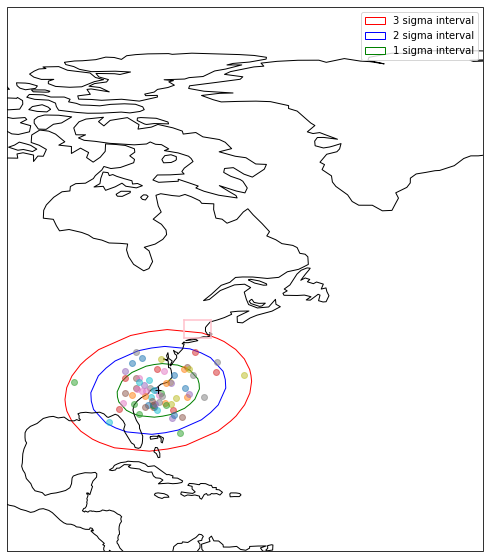

In [19]:
plotTMinusPosition(hurdat, 30, ['TD', 'HU', 'TS', 'SS', 'EX'], lon_min=-74, lon_max=-70, lat_min=41.25, lat_max=44)

70 storms plotted


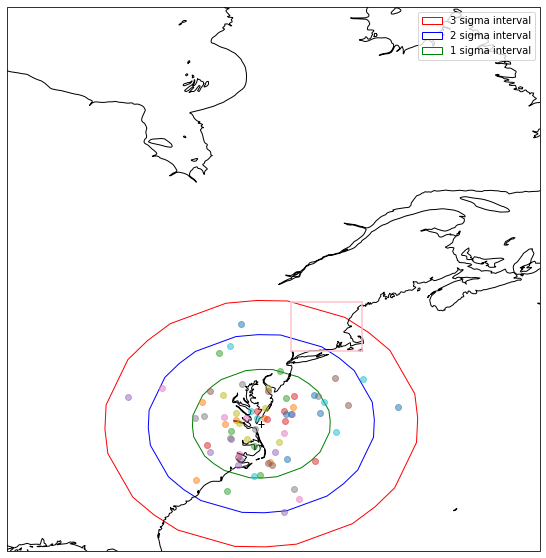

In [20]:
plotTMinusPosition(hurdat, 15, ['TD', 'HU', 'TS', 'SS', 'EX'], lon_min=-74, lon_max=-70, lat_min=41.25, lat_max=44, bounds = [-90, -60, 30, 60])

70 storms plotted


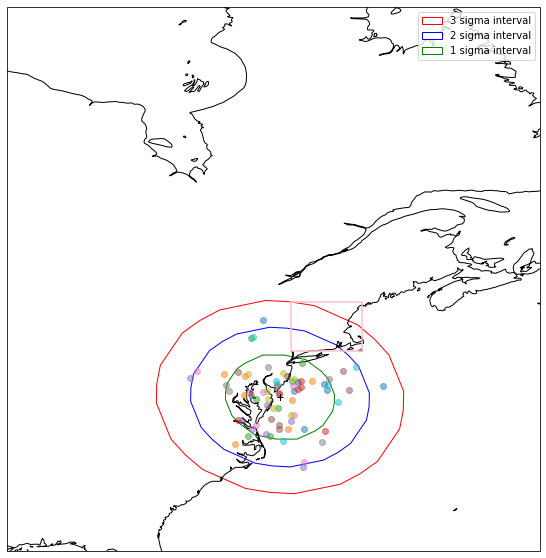

In [21]:
plotTMinusPosition(hurdat, 10, ['TD', 'HU', 'TS', 'SS', 'EX'], lon_min=-74, lon_max=-70, lat_min=41.25, lat_max=44, bounds = [-90, -60, 30, 60])

70 storms plotted


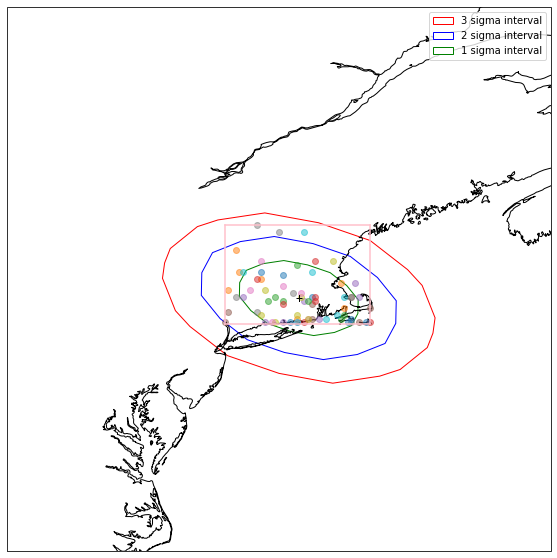

In [22]:
plotTMinusPosition(hurdat, 0, ['TD', 'HU', 'TS', 'SS', 'EX'], lon_min=-74, lon_max=-70, lat_min=41.25, lat_max=44, bounds = [-80, -65, 35, 50])